### Named Entity Recognition Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import json
import nltk
import spacy
import glob
import os
import re
import openpyxl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

#### A. Preliminaries

In [3]:
# read data aggregate
def read_data(files):
    all = []
    for file in files:
        try:
            with open(file, 'r') as doc:
                data = [json.loads(line) for line in doc]
                all.extend(data)
        except Exception as e: 
            print(f"Error reading file '{file}': {e}")

    return all

In [4]:
all_files = glob.glob('data/' + '*.jsonl')
data_list = read_data(all_files)
data_df = pd.DataFrame(data_list)

Error reading file 'data/NER Cohort 1-EN-F.jsonl': Expecting value: line 2 column 1 (char 1)


In [5]:
# load spacy english model
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

/Users/janinedevera/Documents/UNDP/NER/named-entity-recognition-undp/ner-env/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.7.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


#### B. Data Quality Checks (Corpus)
##### Duplicates

In [150]:
def preprocess_text(docs):
    texts = [nlp(x) for x in docs]
    result = []

    for text in texts: 
        tokens = [token.lemma_ for token in text if not token.is_stop and token.is_alpha or token.is_digit]
        result.append(" ".join(tokens))

    return result

In [151]:
# extract text as list 
text_list = [x['text'] for x in data_list]
text_processed = preprocess_text(text_list)

/Users/janinedevera/Documents/UNDP/NER/named-entity-recognition-undp/ner-env/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [8]:
# vectorize and compute similarity score
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(text_processed)
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
similarity_threshold = 0.98

In [9]:
# extract duplicate texts 
duplicates = set()
for i in range(len(text_list)):
    for j in range(i + 1, len(text_list)):
        if similarity_matrix[i, j] > similarity_threshold:
            duplicates.add((i, j))
print(f"Number of duplicates: {len(duplicates)}")

Number of duplicates: 34


##### Language

In [10]:
lang_list = set([x['language'] for x in data_list])
lang_list

{'eng'}

##### Null Labels

In [11]:
# check number of texts with no labels
no_labels = [(item["text"], item["label"]) for item in data_list if not item["label"]]
print(f"Number of empty lists: {len(no_labels)}")

Number of empty lists: 3167


In [12]:
for text, label in no_labels:
    print(f"Text: {text}")

Text: A MAJOR OBSTACLE on the road to our countries’ social and economic progress.
Text: The partnership also provided for the drilling of wells.
Text: The limitation of the liability of shareholders to the amount outstanding on the shares, by enlarging the number of potential participants in business finance, extends very greatly the capital "watershed".
Text: The family of analytical techniques for examining economic environmental policies and decisions includes traditional project level cost-benefit analysis, cost-effectiveness analysis, multicriteria analysis and decision analysis.
Text: Thus, enabling the housing sector to work better is critical for preventing the multiplication of slums and promoting sustainable urban development.
Text: Do gender relations within health services affect the process of health sector reform, attempts should not be the experiences of users?
Text: They are also more vulnerable to violence like sexual assault and abuse during environmental crises.
Tex

#### C. Data Quality Checks (Group)

##### Label Cardinality
Average number of labels assigned to each instance in a dataset

*https://www.professores.uff.br/fcbernardini/wp-content/uploads/sites/68/2017/08/2Bernardini_Barbosa_Meza-ENIAC2013.pdf*

In [41]:
# separate dataset by group/volunteer
groups = set(x['group'] for x in data_list)

grouped_data = []
for value in groups:
    group = [d for d in data_list if d['group'] == value]
    grouped_data.append(group)

In [40]:
# label list by group/volunteer
label_list = []
for group in grouped_data:
    labels = [x['label'] for x in group]
    label_list.append(labels)

ent_list = [[[
    [item for item in sublist if isinstance(item, str)]
    for sublist in inner_list_1
] for inner_list_1 in inner_list_2] for inner_list_2 in label_list]


In [15]:
# calculate label cardinality
for index, group in enumerate(ent_list): 
    total_labels = sum(len(instance_lables) for instance_lables in group)
    n = len(group)
    cardinality = total_labels / n
    print(f"Cardinality of group {index+1}: {cardinality:.3f}")


Cardinality of group 1: 2.581
Cardinality of group 2: 2.401
Cardinality of group 3: 2.643
Cardinality of group 4: 2.000
Cardinality of group 5: 2.231
Cardinality of group 6: 2.149
Cardinality of group 7: 2.876
Cardinality of group 8: 1.823
Cardinality of group 9: 1.879
Cardinality of group 10: 1.824
Cardinality of group 11: 2.306
Cardinality of group 12: 2.714
Cardinality of group 13: 2.154


##### Label Density
Average number of labels assigned to each instance out of total unique labels

In [16]:
# calculate label density
for index, group in enumerate(ent_list):
    label_sum = 0
    for sublist in group: 
        unique_labels = len(list(set([item for inner_list in sublist for item in inner_list])))
        label_sum += unique_labels
    n = len(list(set([item for sublist in group for inner_list in sublist for item in inner_list])))
    mean_labels = label_sum / n
    density = mean_labels / len(group)
    print(f"Density of group {index+1}: {density:.3f}, size of group: {len(group)}, unique labels: {n}")

Density of group 1: 0.086, size of group: 372, unique labels: 21
Density of group 2: 0.076, size of group: 2500, unique labels: 22
Density of group 3: 0.079, size of group: 2010, unique labels: 22
Density of group 4: 0.108, size of group: 20, unique labels: 12
Density of group 5: 0.073, size of group: 2089, unique labels: 21
Density of group 6: 0.075, size of group: 342, unique labels: 20
Density of group 7: 0.093, size of group: 688, unique labels: 22
Density of group 8: 0.064, size of group: 1304, unique labels: 20
Density of group 9: 0.065, size of group: 1129, unique labels: 21
Density of group 10: 0.063, size of group: 2010, unique labels: 21
Density of group 11: 0.075, size of group: 2500, unique labels: 21
Density of group 12: 0.105, size of group: 49, unique labels: 18
Density of group 13: 0.070, size of group: 2020, unique labels: 22


##### Label Distribution by Group

In [17]:
ent_dict = {}
for index, group in enumerate(ent_list):
    group_labels = [item for sublist in group for inner_list in sublist for item in inner_list]
    frequency_counter = Counter(group_labels)
    percent = {label: count / len(group_labels) for label, count in frequency_counter.items()}
    ent_dict[index + 1] = percent

In [18]:
rows = list(ent_dict.keys())
columns = sorted(set(col for row_dict in ent_dict.values() for col in row_dict.keys()))
ent_array = [[ent_dict[row].get(col, 0) for col in columns] for row in rows]

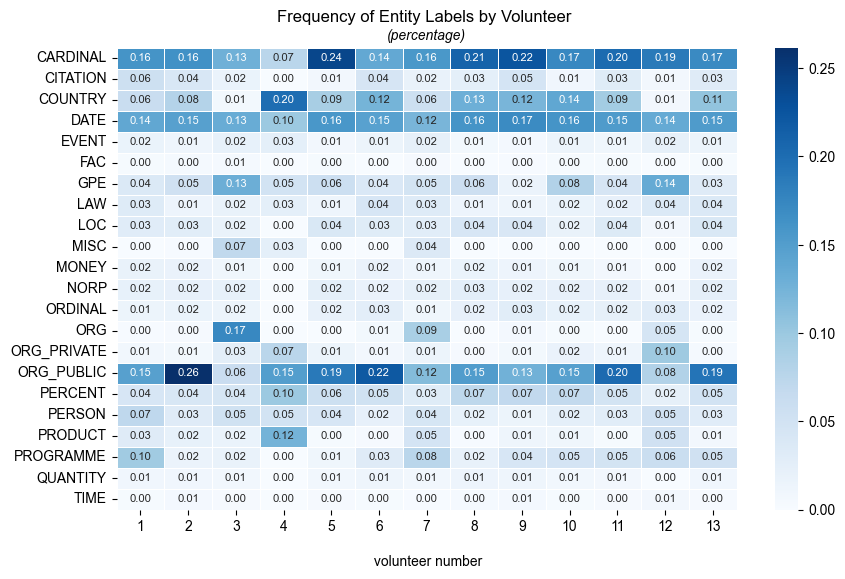

In [19]:
rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(10, 6)) 
sns.heatmap(np.transpose(ent_array), fmt=".2f", cmap="Blues", xticklabels=rows, yticklabels=columns,
            linewidth=.5, annot=True, annot_kws={"size": 8})
plt.xlabel('\n volunteer number')
plt.title('Frequency of Entity Labels by Volunteer \n')
plt.text(0.5, 1.01, "(percentage)", horizontalalignment='center', verticalalignment='bottom', 
         transform=ax.transAxes, fontstyle='italic')
plt.savefig('plots/01 label distribution.png', dpi=300)
plt.show()

##### Label Distribution Total

In [20]:
label_list = [x['label'] for x in data_list]
flattened_list = [item for sublist in label_list for item in sublist]

ent_list = [item[2] for item in flattened_list] # extract only entity labels
frequency_counter = Counter(ent_list)
for item, frequency in frequency_counter.items():
    print(f"{item}: {frequency}")

CARDINAL: 6898
FAC: 111
QUANTITY: 362
NORP: 853
GPE: 2313
PRODUCT: 480
DATE: 5705
ORG_PUBLIC: 6498
ORDINAL: 737
LOC: 1205
PERSON: 1315
PROGRAMME: 1326
COUNTRY: 3289
PERCENT: 1940
EVENT: 509
CITATION: 1012
LAW: 787
ORG_PRIVATE: 488
MONEY: 497
TIME: 151
ORG: 1172
MISC: 456


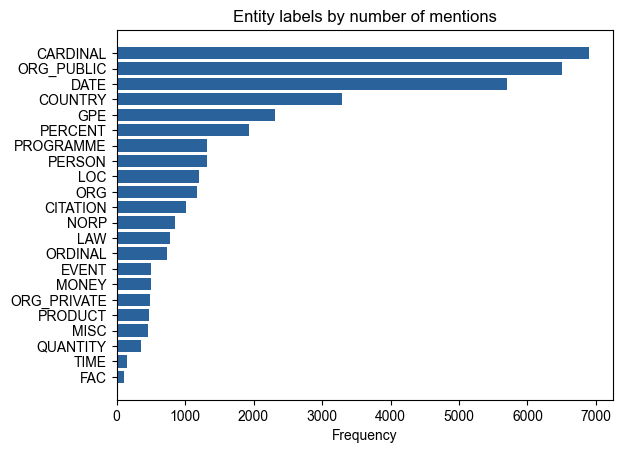

In [21]:
items, frequencies = zip(*sorted(frequency_counter.items(), key=lambda x: x[1]))

plt.barh(items, frequencies, color='#2a639c')
plt.xlabel('Frequency')
plt.title('Entity labels by number of mentions')
plt.show()

##### Token Length

In [101]:
texts = [nlp(x) for x in text_list]
num_tokens = [len(text) for text in texts]

/Users/janinedevera/Documents/UNDP/NER/named-entity-recognition-undp/ner-env/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [174]:
min, max = np.min(num_tokens), np.max(num_tokens)
mean, med, sd = np.mean(num_tokens), np.median(num_tokens), np.std(num_tokens)

print(f"Summary Statistics: \n Min = {min} \n Max = {max} \n Mean = {round(mean, 1)} \n Median = {round(med, 1)} \n SD = {round(sd,1)}")

Summary Statistics: 
 Min = 5 
 Max = 256 
 Mean = 30.4 
 Median = 27.0 
 SD = 18.7


In [ ]:
matching_indices = [i for i, num in enumerate(num_tokens) if num == min]

if matching_indices:
    for index in matching_indices:
        print(f"Text {index}: {text_list[index]}")

#### D. Qualitative Checks

In [39]:
# add entity labels into dataframe columns

# extract labels as dictionary per row (key = label, value = span)
def extract_labels(row):
    labels_dict = {}
    for span in row:
        label = span[2]
        value = list(span[:2])
        labels_dict[label] = labels_dict.get(label, []) + [value]
    return labels_dict

data_df['extracted_labels'] = data_df['label'].apply(extract_labels)

# convert label dictionary to columns
df_labels = pd.DataFrame(data_df['extracted_labels'].tolist(), index=data_df.index)
df = pd.concat([data_df, df_labels], axis=1)
df = df.drop(['extracted_labels'], axis=1)


##### ORG_PUBLIC

Note: 
* Common noun phrases pertaining to proper nouns are included in the tagging (e.g. "Specialized Agencies", "Working Group")
* Countries (e.g. Yemen), People (e.g. Lebanese)

In [40]:
# extract tagged words based on span
def extract_words(text, positions):
    words = []
    try:
        if isinstance(positions, list):
            text = text.lower()
            for start, end in positions:
                words.append(text[start:end])
        else:
            raise ValueError("Positions should be a list of tuples.")
    except Exception as e:
        print(f"Error extracting words: {e}")
        return "Error"

    return '; '.join(words)

# extract df by label / volunteer
def extract_df(df, label):
    subset = df[df[label].notna()][['text', 'group', label]].copy()
    subset['words'] = subset.apply(lambda row: extract_words(row['text'], row[label]), axis = 1)
    return subset

# extract sample
def extract_sample(df, label, n, random_state=999, print_output=True):
    subset = extract_df(df, label)
    sampledf = subset.sample(frac=n, random_state=random_state).sort_values(by='group')

    if print_output:
        for index, row in sampledf.iterrows():
            print(f"Group {row['group']:}: {row['words']}")

    return sampledf

In [565]:
sample_org_pub = extract_sample(df, 'ORG_PUBLIC', 0.01)

Group A: the international reconstruction fund facility for iraq
Group A: unep
Group B: wfp mozambique; the government of mozambique; wfp
Group B: world vision south sudan
Group B: fifarma; national regulatory authority; cecmed; the pan american network for drug regulatory harmonization; pandrh
Group B: malaysian aids council
Group B: the sub-committee; the informal open ended working group
Group B: comesa; eastern and southern africa trade and development bank; pta bank
Group B: unesco institute for statistics
Group B: government
Group C: westminster parliament
Group E: wfp
Group E: the minister of ministry of justice
Group E: the general assembly
Group E: wfp
Group G: world health organization
Group G: university of bern
Group G: who
Group G: pan american health organization; paho; who; who
Group G: unep; unep
Group G: paho
Group G: un-habitat
Group G: wfp; the asian development bank
Group G: the palestinian ministry of health
Group H: wipo green’s
Group I: the india country office
G

##### ORG_PRIVATE

Note: 
* Some public organizaitons are included

In [235]:
sample_org_private = extract_sample(df, 'ORG_PRIVATE', 0.05)

Group A: University of Pennsylvania Press
Group B: Saudi Electricity Company; Saudi Basic Industries Corporation
Group B: Banco del Pacifico
Group C: MHolland
Group E: JFC
Group H: CAPMAS
Group H: The King’s Fund
Group H: ITU
Group I: CinnaGen; PersisGen
Group I: Telegram
Group I:  polling firm Baseera 
Group K: Thomson Reuters
Group M: JECFA
Group M: StratAgile PTE Ltd.
Group M: the Anti-Narcotics Administration; Anti-Narcotics Administration
Group M: key Government officials; migrant centres; migrant centres
Group M: BULOG
Group N: the United Nations


##### ORG

In [236]:
sample_org = extract_sample(df, 'ORG', 0.05)

Group A: GII
Group G: GII
Group H: the PCT System
Group H: The Standing Police Capacity; UNAMI; the United Nations Office
Group H: Anticipatory Action
Group H: GF
Group H: the Department of Trade; Co-ordinating Committee
Group K: EO
Group M: Committee; the General Assembly
Group M: children1
Group M: Lebanon State
Group M: The Nol"'·regian Government
Group M: CDEMA ; WFP
Group M: UNIDO
Group M: United Nations Department of Economic and Social Affairs/Population Division International Migration Report
Group M: Parliament
Group M: The Executive Committee
Group M: The First Committee
Group M: WFP
Group M: Commission
Group M: government agencies
Group M: Socialist Republic Union of Soviet; Socialist Republics; United States of America; Sub-Committee for the examination of COf'respondetlce Byelorussian Soviet; Socialist Republic China Dominican' Republic Drafting Committee
Group M: HIPC; non-governmental groups; Jubilee 2000 initiative of church-led groups
Group M: Pakista
Group M: Organiza

##### CITATION

In [237]:
sample_cit = extract_sample(df, 'CITATION', 0.05)

Group A: Baland J-M and Duprez C (2007
Group A: E/2021/26 E/CN.5/2021/9 38/56 21-02968 13
Group A: 11,12
Group A: Geneva, World Health Organization, 2004 (WHO/CDS/CPE/PVC/2004.10)
Group A: American Journal of Tropical Medicine and Hygiene 1996; 55(1):1–11
Group A: 47 
Group B: 3; 1
Group B: World Health Organization, 2012
Group B: 72 ; ,73; 4
Group B: (figure 6.11)
Group B: (A/65/354–S/2010/466)
Group B: (A/C.3/L.l974/Rev.l)
Group C: A/HRC/30/9/Add.1 6/9 GE.15-15525
Group E: Carr (2002), Marra et al
Group E: (Cuddington and Jerret, 2008)
Group E: Berner, E., (2002), “Learning from informal markets: innovative approaches to land and housing provision”, in Westendorff, D. and Eade, D., (eds.), Development and cities: Essays from development in practice, Oxfam, Oxford, pp
Group E: Cochrane Database of Systematic Reviews 2019, Issue 10
Group E: (Figure 1)
Group E: E/CN.4/Sub.2/L.583 English Page 4 7
Group G: IPC in 2022-2023
Group H: Matsuura 1998
Group H: Report—23
Group I: Rogelj et al. 

##### PROGRAMME

In [238]:
sample_prog = extract_sample(df, 'PROGRAMME', 0.05)

Group A: UN-Women strategic plan
Group A: Integrating Climate Change Risks and Opportunities into National Development Processes and UN Country Programming; Climate Risk Project
Group A: UN-REDD Programme
Group A: the HS & the HC
Group B: LRSP
Group B: HTA; HTA
Group B: Flash Appeal (FA) ; Consolidated Appeal (CA) 
Group B: NCAP: National Clean Air Programme
Group B: the Complementary Pension Regime; RPC
Group B: GII ; GII
Group B: ife FitforREACH, 
Group B: CSP
Group B: market intervention initiative
Group C: Plantation Sector Education Development Project (PSEDP)
Group C: National Strategy on Financial Inclusion
Group E: SDG 3
Group E: Social Security Programs
Group E: the Food Assistance for Assets (FFA) Project
Group E: the New Urban Agenda
Group E: TECHNOLOGY AND INNOVATION SUPPORT CENTERS – TISCs
Group E: UNFPA-UNICEF Global Programme to End Child Marriage 
Group E: A Sustainable Consumption and Production National Action Plan
Group E: UHC
Group E: Global Fund
Group E: the Strate

#### E. Quantitative Checks

In [41]:
# function for cleaning strings 
def clean_strings(words):
    cleaned_words = []
    for word in words.split(';'):
        cleaned_word = re.sub(r'[^a-zA-Z\s]', '', str(word)).strip() # retain alpha characters, remove trailing spaces
        if cleaned_word and len(cleaned_word) > 1: # remove single letters 
            cleaned_word = re.sub(r'^(the|he)\s', '', cleaned_word) # remove "the" at the start of a string
            cleaned_words.append(cleaned_word)
    return cleaned_words

In [42]:
# function for extracting top entities 
def top_entities(df, label, n, print_output=True):
    # extract subset dataframe, labels, and remove NAs
    df_new = extract_df(df, label)
    df_new = df_new.loc[df_new[label].apply(lambda x: len(x) > 0)]

    # clean text 
    df_new['words_clean'] = df_new['words'].apply(clean_strings)

    # list of unique terms and frequencies 
    words_raw = [word for sublist in df_new['words_clean'] for word in sublist]
    words_count = Counter(words_raw)
    words_topn = dict(words_count.most_common(n))

    # save results in dataframe
    result_df = pd.DataFrame(words_topn.items(), columns =['Entity', 'Count'])

    # print results
    if print_output:
        single_count = sum(1 for c in words_count.values() if c == 1)
        total = sum(words_count.values())
        top20 = sum(dict(words_count.most_common(n)).values())

        print(f"{label}")
        print(f"Total of top 20 entities: {top20}")
        print(f"Total number of entities tagged: {total}")
        print(f"Share of top {n} entities: {top20/total*100:.2f}%")
        print(f"Number of unique entities: {len(words_count)}")
        print(f"Number of entities mentioned once: {single_count}\n")
        for word, count in words_topn:
            print(f"{word}: {count}")
        print("\n")

    return result_df

# function for saving output
def save_to_excel(df_list, excel_filename):
    with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
        for label, result_df in df_list.items():
            result_df = pd.concat([result_df, pd.DataFrame(columns=result_df.columns)])
            result_df.to_excel(writer, sheet_name=label, index=False)

##### Aggregate

In [43]:
# combine ORG, ORG_PUBLIC, ORG_PRIVATE
df['ORG_NEW'] = df.apply(lambda row: (
    row['ORG_PUBLIC'] if isinstance(row['ORG_PUBLIC'], list) else []) +
    (row['ORG_PRIVATE'] if isinstance(row['ORG_PRIVATE'], list) else []) +
    (row['ORG'] if isinstance(row['ORG'], list) else []), axis=1)

In [689]:
all_labels = ['COUNTRY', 'GPE', 'NORP', 'ORG_NEW', 'PERSON']
result_dfs = {}

for label in all_labels:
    result_dfs[label] = top_entities(df, label, 20, print_output=False)
    
save_to_excel(result_dfs, 'output_aggregate.xlsx')

##### Volunteer

In [690]:
# function for extracting top entities per volunteer
def top_entities_volunteer(df, volunteer_list, label_list, excel_filename):
    with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:

        for label in label_list:
            label_df = pd.DataFrame()

            for volunteer in volunteer_list:
                subset = df[df['group'] == volunteer].copy()
                result_df = top_entities(subset, label, 20, print_output=False)
                label_df[f'{volunteer}_Entity'] = result_df['Entity']
                label_df[f'{volunteer}_Count'] = result_df['Count']

            label_df.to_excel(writer, sheet_name=label, index=False)


In [691]:
all_labels = ['COUNTRY', 'GPE', 'NORP', 'ORG_NEW', 'PERSON']
volunteer_list = sorted(df['group'].unique())

top_entities_volunteer(df, volunteer_list, all_labels, 'output_volunteers.xlsx')

Error extracting words: Positions should be a list of tuples.


#### F. Clean Dataset

In [140]:
# drop selected volunteers volunteers 
drop = ['H', 'J', 'M']
df_new = df.apply(lambda row: row[~df['group'].isin(drop)])

In [141]:
# keep only a subset of entities 
subset = df_new.loc[:, 'id':'Comments']

final_entities = ['COUNTRY', 'DATE', 'GPE', 'MONEY', 'ORG_NEW', 'NORP']
subset2 = df_new[final_entities]

df_new = pd.concat([subset, subset2], axis=1)
df_new.rename(columns={'ORG_NEW': 'ORG'}, inplace=True)

In [142]:
# create new label column with selected entities 
final_entities = ['COUNTRY', 'DATE', 'GPE', 'MONEY', 'ORG', 'NORP']
for column in final_entities:
    df_new[column] = df_new[column].apply(lambda x: [item + [column] for item in x if column not in item] if isinstance(x, list) else x)
    df_new[column] = df_new[column].apply(lambda x: np.nan if isinstance(x, list) and not x else x)

df_new = df_new.drop('label', axis=1)
df_new['label'] = df_new[final_entities].apply(lambda row: [inner for sublist in row if isinstance(sublist, list) for inner in sublist], axis=1)
df_new = df_new.drop(final_entities, axis=1)

In [145]:
df_new.to_json('ner_clean.jsonl', orient='records', lines=True)